In [1]:
import feature_extraction as fe

import numpy as np

import os
import random
import pickle
import warnings
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 3
random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')

In [2]:
def data_batcher(data, batch_size):
    random.shuffle(data)
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

In [3]:
dataset = 'GTZAN'
new_feats = False


dataset_filename = f'../datasets/{dataset}.gui'
pickle_filename = f'./feats_spects-pickles/{dataset_filename.split("/")[-1][:-4]}_feats.pkl'
if new_feats or not os.path.isfile(pickle_filename):
    feats, labels = fe.extract_numfeats(dataset_filename)
    with open(pickle_filename, 'wb') as f:
        pickle.dump([feats, labels], f)
else:
    with open(pickle_filename, 'rb') as f:
        feats, labels = pickle.load(f)
    print(f'{feats.shape[0]} features extracted')

1000 features extracted


In [4]:
scaler = StandardScaler()
scaled_feats = scaler.fit_transform(feats)

x_trainval, x_test, y_trainval, y_test = train_test_split(scaled_feats, labels, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.25)

train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
test_data = [(x, y) for x, y in zip(x_test, y_test)]

print(len(train_data), "training samples")
print(len(val_data), "validation samples")
print(len(test_data), "test samples")

600 training samples
200 validation samples
200 test samples


In [5]:
# Fully connected neural network with one hidden layer
class DNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DNNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = nn.Linear(hidden_size[2], hidden_size[3])
        self.fc5 = nn.Linear(hidden_size[3], num_classes)
        
        self.bn2 = nn.BatchNorm1d(hidden_size[1])
        self.bn3 = nn.BatchNorm1d(hidden_size[2])
        self.bn4 = nn.BatchNorm1d(hidden_size[3])
        
        self.drop_layer = nn.Dropout(p=0.3)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop_layer(x)
        x = self.bn2(F.relu(self.fc2(x)))
        x = self.drop_layer(x)
        x = self.bn3(F.relu(self.fc3(x)))
        x = self.drop_layer(x)
        x = self.bn4(F.relu(self.fc4(x)))
        x = self.fc5(x)
        return x # we can return here the softmax, but then we should use the nll_loss instead of the cross_entropy

In [6]:
def train(log_interval, model, device, data_batches, optimizer, epoch):
    losses = []
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.train()
    
    for i, batch in enumerate(data_batches):
        x, y = list(zip(*batch))
        
        # Move tensors to the configured device
        data = torch.from_numpy(np.array(x)).float().to(device)
        target = torch.from_numpy(np.array(y)).to(device)
        
        # clear all the gradients of the optimized tensors
        optimizer.zero_grad()
    
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (i+1) % log_interval == 0:
            print(f'Train Epoch: {epoch+1} [{(i+1)*len(data)}/{len_glob_data} ({str(int(100. * (i+1)*len(data) / len_glob_data)).zfill(2)}%)]\tLoss: {round(loss.item(),6)}')
    return np.array(losses).mean()

In [7]:
def validate(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = []
    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            validation_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss = np.array(validation_loss).mean()
    accuracy = 100. * correct / len_glob_data

    print(f'\nValidation set: Average loss: {round(validation_loss, 4)}, Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy, validation_loss

In [8]:
# Hyperparameters

input_size = 25
hidden_size = [256, 128, 64, 32]
num_classes = 10

train_batch_size = 100
valid_batch_size = 100

num_epochs = 1000
learning_rate = 0.0001

In [10]:
train_data_batches = data_batcher(train_data, train_batch_size)
val_data_batches = data_batcher(val_data, valid_batch_size)

model = DNNClassifier(input_size, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []
accuracies = []

for epoch in range(num_epochs):
    
    train_loss = train(2, model, device, train_data_batches, optimizer, epoch)
    train_losses.append(train_loss)

    accuracy, valid_loss = validate(model, device, val_data_batches)
    valid_losses.append(valid_loss)
    accuracies.append(accuracy)

Train Epoch: 1 [200/600 (33%)]	Loss: 2.334399
Train Epoch: 1 [400/600 (66%)]	Loss: 2.332408
Train Epoch: 1 [600/600 (100%)]	Loss: 2.352933

Validation set: Average loss: 2.3156, Accuracy: 15/200 (7%)

Train Epoch: 2 [200/600 (33%)]	Loss: 2.275258
Train Epoch: 2 [400/600 (66%)]	Loss: 2.254499
Train Epoch: 2 [600/600 (100%)]	Loss: 2.341716

Validation set: Average loss: 2.3157, Accuracy: 15/200 (7%)

Train Epoch: 3 [200/600 (33%)]	Loss: 2.251142
Train Epoch: 3 [400/600 (66%)]	Loss: 2.320536
Train Epoch: 3 [600/600 (100%)]	Loss: 2.28499

Validation set: Average loss: 2.3127, Accuracy: 15/200 (7%)

Train Epoch: 4 [200/600 (33%)]	Loss: 2.237704
Train Epoch: 4 [400/600 (66%)]	Loss: 2.299631
Train Epoch: 4 [600/600 (100%)]	Loss: 2.263283

Validation set: Average loss: 2.3034, Accuracy: 14/200 (7%)

Train Epoch: 5 [200/600 (33%)]	Loss: 2.324008
Train Epoch: 5 [400/600 (66%)]	Loss: 2.296022
Train Epoch: 5 [600/600 (100%)]	Loss: 2.272242

Validation set: Average loss: 2.2875, Accuracy: 14/200 (7

Train Epoch: 42 [600/600 (100%)]	Loss: 1.92369

Validation set: Average loss: 1.9513, Accuracy: 71/200 (35%)

Train Epoch: 43 [200/600 (33%)]	Loss: 1.953187
Train Epoch: 43 [400/600 (66%)]	Loss: 1.953417
Train Epoch: 43 [600/600 (100%)]	Loss: 1.891384

Validation set: Average loss: 1.9461, Accuracy: 71/200 (35%)

Train Epoch: 44 [200/600 (33%)]	Loss: 1.908493
Train Epoch: 44 [400/600 (66%)]	Loss: 1.945443
Train Epoch: 44 [600/600 (100%)]	Loss: 1.928184

Validation set: Average loss: 1.9352, Accuracy: 74/200 (37%)

Train Epoch: 45 [200/600 (33%)]	Loss: 1.901321
Train Epoch: 45 [400/600 (66%)]	Loss: 1.937276
Train Epoch: 45 [600/600 (100%)]	Loss: 1.933489

Validation set: Average loss: 1.9325, Accuracy: 74/200 (37%)

Train Epoch: 46 [200/600 (33%)]	Loss: 1.89861
Train Epoch: 46 [400/600 (66%)]	Loss: 1.953052
Train Epoch: 46 [600/600 (100%)]	Loss: 1.908265

Validation set: Average loss: 1.9245, Accuracy: 75/200 (37%)

Train Epoch: 47 [200/600 (33%)]	Loss: 1.868457
Train Epoch: 47 [400/600

Train Epoch: 83 [200/600 (33%)]	Loss: 1.724908
Train Epoch: 83 [400/600 (66%)]	Loss: 1.799931
Train Epoch: 83 [600/600 (100%)]	Loss: 1.731254

Validation set: Average loss: 1.725, Accuracy: 99/200 (49%)

Train Epoch: 84 [200/600 (33%)]	Loss: 1.686241
Train Epoch: 84 [400/600 (66%)]	Loss: 1.735943
Train Epoch: 84 [600/600 (100%)]	Loss: 1.669692

Validation set: Average loss: 1.7159, Accuracy: 97/200 (48%)

Train Epoch: 85 [200/600 (33%)]	Loss: 1.682564
Train Epoch: 85 [400/600 (66%)]	Loss: 1.720317
Train Epoch: 85 [600/600 (100%)]	Loss: 1.722005

Validation set: Average loss: 1.7131, Accuracy: 98/200 (49%)

Train Epoch: 86 [200/600 (33%)]	Loss: 1.670679
Train Epoch: 86 [400/600 (66%)]	Loss: 1.716364
Train Epoch: 86 [600/600 (100%)]	Loss: 1.66262

Validation set: Average loss: 1.7048, Accuracy: 100/200 (50%)

Train Epoch: 87 [200/600 (33%)]	Loss: 1.724288
Train Epoch: 87 [400/600 (66%)]	Loss: 1.754911
Train Epoch: 87 [600/600 (100%)]	Loss: 1.688033

Validation set: Average loss: 1.7014, 

Train Epoch: 123 [400/600 (66%)]	Loss: 1.533475
Train Epoch: 123 [600/600 (100%)]	Loss: 1.579172

Validation set: Average loss: 1.5215, Accuracy: 113/200 (56%)

Train Epoch: 124 [200/600 (33%)]	Loss: 1.537181
Train Epoch: 124 [400/600 (66%)]	Loss: 1.595929
Train Epoch: 124 [600/600 (100%)]	Loss: 1.525001

Validation set: Average loss: 1.519, Accuracy: 113/200 (56%)

Train Epoch: 125 [200/600 (33%)]	Loss: 1.509858
Train Epoch: 125 [400/600 (66%)]	Loss: 1.491989
Train Epoch: 125 [600/600 (100%)]	Loss: 1.536244

Validation set: Average loss: 1.5182, Accuracy: 113/200 (56%)

Train Epoch: 126 [200/600 (33%)]	Loss: 1.500081
Train Epoch: 126 [400/600 (66%)]	Loss: 1.538709
Train Epoch: 126 [600/600 (100%)]	Loss: 1.53812

Validation set: Average loss: 1.5099, Accuracy: 115/200 (57%)

Train Epoch: 127 [200/600 (33%)]	Loss: 1.489873
Train Epoch: 127 [400/600 (66%)]	Loss: 1.558365
Train Epoch: 127 [600/600 (100%)]	Loss: 1.483372

Validation set: Average loss: 1.5082, Accuracy: 116/200 (58%)

Train

Train Epoch: 164 [600/600 (100%)]	Loss: 1.39165

Validation set: Average loss: 1.3536, Accuracy: 119/200 (59%)

Train Epoch: 165 [200/600 (33%)]	Loss: 1.289127
Train Epoch: 165 [400/600 (66%)]	Loss: 1.399424
Train Epoch: 165 [600/600 (100%)]	Loss: 1.391458

Validation set: Average loss: 1.3476, Accuracy: 119/200 (59%)

Train Epoch: 166 [200/600 (33%)]	Loss: 1.355315
Train Epoch: 166 [400/600 (66%)]	Loss: 1.376157
Train Epoch: 166 [600/600 (100%)]	Loss: 1.338988

Validation set: Average loss: 1.3482, Accuracy: 120/200 (60%)

Train Epoch: 167 [200/600 (33%)]	Loss: 1.320048
Train Epoch: 167 [400/600 (66%)]	Loss: 1.3614
Train Epoch: 167 [600/600 (100%)]	Loss: 1.365386

Validation set: Average loss: 1.3436, Accuracy: 120/200 (60%)

Train Epoch: 168 [200/600 (33%)]	Loss: 1.308437
Train Epoch: 168 [400/600 (66%)]	Loss: 1.392875
Train Epoch: 168 [600/600 (100%)]	Loss: 1.329988

Validation set: Average loss: 1.3436, Accuracy: 122/200 (61%)

Train Epoch: 169 [200/600 (33%)]	Loss: 1.333857
Train 

Train Epoch: 204 [200/600 (33%)]	Loss: 1.189033
Train Epoch: 204 [400/600 (66%)]	Loss: 1.176233
Train Epoch: 204 [600/600 (100%)]	Loss: 1.223426

Validation set: Average loss: 1.2272, Accuracy: 129/200 (64%)

Train Epoch: 205 [200/600 (33%)]	Loss: 1.093145
Train Epoch: 205 [400/600 (66%)]	Loss: 1.236612
Train Epoch: 205 [600/600 (100%)]	Loss: 1.176234

Validation set: Average loss: 1.2176, Accuracy: 129/200 (64%)

Train Epoch: 206 [200/600 (33%)]	Loss: 1.181502
Train Epoch: 206 [400/600 (66%)]	Loss: 1.148162
Train Epoch: 206 [600/600 (100%)]	Loss: 1.172156

Validation set: Average loss: 1.2224, Accuracy: 129/200 (64%)

Train Epoch: 207 [200/600 (33%)]	Loss: 1.125653
Train Epoch: 207 [400/600 (66%)]	Loss: 1.192245
Train Epoch: 207 [600/600 (100%)]	Loss: 1.120911

Validation set: Average loss: 1.2187, Accuracy: 128/200 (64%)

Train Epoch: 208 [200/600 (33%)]	Loss: 1.185739
Train Epoch: 208 [400/600 (66%)]	Loss: 1.210267
Train Epoch: 208 [600/600 (100%)]	Loss: 1.199509

Validation set: Av

Train Epoch: 245 [200/600 (33%)]	Loss: 1.027424
Train Epoch: 245 [400/600 (66%)]	Loss: 0.999166
Train Epoch: 245 [600/600 (100%)]	Loss: 1.038226

Validation set: Average loss: 1.1222, Accuracy: 134/200 (67%)

Train Epoch: 246 [200/600 (33%)]	Loss: 1.063655
Train Epoch: 246 [400/600 (66%)]	Loss: 1.035269
Train Epoch: 246 [600/600 (100%)]	Loss: 0.999844

Validation set: Average loss: 1.1225, Accuracy: 136/200 (68%)

Train Epoch: 247 [200/600 (33%)]	Loss: 0.955476
Train Epoch: 247 [400/600 (66%)]	Loss: 1.00809
Train Epoch: 247 [600/600 (100%)]	Loss: 1.014709

Validation set: Average loss: 1.1224, Accuracy: 135/200 (67%)

Train Epoch: 248 [200/600 (33%)]	Loss: 0.970456
Train Epoch: 248 [400/600 (66%)]	Loss: 1.004425
Train Epoch: 248 [600/600 (100%)]	Loss: 1.008238

Validation set: Average loss: 1.1193, Accuracy: 135/200 (67%)

Train Epoch: 249 [200/600 (33%)]	Loss: 1.063473
Train Epoch: 249 [400/600 (66%)]	Loss: 1.060215
Train Epoch: 249 [600/600 (100%)]	Loss: 1.039671

Validation set: Ave

Train Epoch: 285 [600/600 (100%)]	Loss: 0.826148

Validation set: Average loss: 1.0532, Accuracy: 138/200 (69%)

Train Epoch: 286 [200/600 (33%)]	Loss: 0.920464
Train Epoch: 286 [400/600 (66%)]	Loss: 0.84815
Train Epoch: 286 [600/600 (100%)]	Loss: 0.835394

Validation set: Average loss: 1.0512, Accuracy: 136/200 (68%)

Train Epoch: 287 [200/600 (33%)]	Loss: 0.938316
Train Epoch: 287 [400/600 (66%)]	Loss: 0.910534
Train Epoch: 287 [600/600 (100%)]	Loss: 0.856178

Validation set: Average loss: 1.0487, Accuracy: 136/200 (68%)

Train Epoch: 288 [200/600 (33%)]	Loss: 0.862242
Train Epoch: 288 [400/600 (66%)]	Loss: 0.92473
Train Epoch: 288 [600/600 (100%)]	Loss: 0.923578

Validation set: Average loss: 1.0462, Accuracy: 136/200 (68%)

Train Epoch: 289 [200/600 (33%)]	Loss: 0.847027
Train Epoch: 289 [400/600 (66%)]	Loss: 0.860314
Train Epoch: 289 [600/600 (100%)]	Loss: 0.890284

Validation set: Average loss: 1.0433, Accuracy: 135/200 (67%)

Train Epoch: 290 [200/600 (33%)]	Loss: 0.859152
Train

Train Epoch: 326 [600/600 (100%)]	Loss: 0.82266

Validation set: Average loss: 1.0067, Accuracy: 137/200 (68%)

Train Epoch: 327 [200/600 (33%)]	Loss: 0.759342
Train Epoch: 327 [400/600 (66%)]	Loss: 0.822624
Train Epoch: 327 [600/600 (100%)]	Loss: 0.755758

Validation set: Average loss: 1.0092, Accuracy: 135/200 (67%)

Train Epoch: 328 [200/600 (33%)]	Loss: 0.82742
Train Epoch: 328 [400/600 (66%)]	Loss: 0.742149
Train Epoch: 328 [600/600 (100%)]	Loss: 0.743216

Validation set: Average loss: 1.0093, Accuracy: 135/200 (67%)

Train Epoch: 329 [200/600 (33%)]	Loss: 0.73998
Train Epoch: 329 [400/600 (66%)]	Loss: 0.66933
Train Epoch: 329 [600/600 (100%)]	Loss: 0.746366

Validation set: Average loss: 1.0109, Accuracy: 135/200 (67%)

Train Epoch: 330 [200/600 (33%)]	Loss: 0.719849
Train Epoch: 330 [400/600 (66%)]	Loss: 0.726754
Train Epoch: 330 [600/600 (100%)]	Loss: 0.746343

Validation set: Average loss: 1.0081, Accuracy: 134/200 (67%)

Train Epoch: 331 [200/600 (33%)]	Loss: 0.743825
Train E

Train Epoch: 369 [400/600 (66%)]	Loss: 0.670316
Train Epoch: 369 [600/600 (100%)]	Loss: 0.66588

Validation set: Average loss: 0.9771, Accuracy: 135/200 (67%)

Train Epoch: 370 [200/600 (33%)]	Loss: 0.638448
Train Epoch: 370 [400/600 (66%)]	Loss: 0.596953
Train Epoch: 370 [600/600 (100%)]	Loss: 0.664141

Validation set: Average loss: 0.9765, Accuracy: 137/200 (68%)

Train Epoch: 371 [200/600 (33%)]	Loss: 0.66786
Train Epoch: 371 [400/600 (66%)]	Loss: 0.772313
Train Epoch: 371 [600/600 (100%)]	Loss: 0.66773

Validation set: Average loss: 0.9779, Accuracy: 136/200 (68%)

Train Epoch: 372 [200/600 (33%)]	Loss: 0.674784
Train Epoch: 372 [400/600 (66%)]	Loss: 0.634426
Train Epoch: 372 [600/600 (100%)]	Loss: 0.721892

Validation set: Average loss: 0.9764, Accuracy: 137/200 (68%)

Train Epoch: 373 [200/600 (33%)]	Loss: 0.596682
Train Epoch: 373 [400/600 (66%)]	Loss: 0.67364
Train Epoch: 373 [600/600 (100%)]	Loss: 0.663929

Validation set: Average loss: 0.98, Accuracy: 137/200 (68%)

Train Epo

Train Epoch: 409 [600/600 (100%)]	Loss: 0.607136

Validation set: Average loss: 0.9656, Accuracy: 132/200 (66%)

Train Epoch: 410 [200/600 (33%)]	Loss: 0.554429
Train Epoch: 410 [400/600 (66%)]	Loss: 0.524234
Train Epoch: 410 [600/600 (100%)]	Loss: 0.534711

Validation set: Average loss: 0.9668, Accuracy: 132/200 (66%)

Train Epoch: 411 [200/600 (33%)]	Loss: 0.564397
Train Epoch: 411 [400/600 (66%)]	Loss: 0.6082
Train Epoch: 411 [600/600 (100%)]	Loss: 0.570767

Validation set: Average loss: 0.9622, Accuracy: 136/200 (68%)

Train Epoch: 412 [200/600 (33%)]	Loss: 0.584865
Train Epoch: 412 [400/600 (66%)]	Loss: 0.632576
Train Epoch: 412 [600/600 (100%)]	Loss: 0.507578

Validation set: Average loss: 0.9605, Accuracy: 135/200 (67%)

Train Epoch: 413 [200/600 (33%)]	Loss: 0.575793
Train Epoch: 413 [400/600 (66%)]	Loss: 0.574824
Train Epoch: 413 [600/600 (100%)]	Loss: 0.548301

Validation set: Average loss: 0.9622, Accuracy: 136/200 (68%)

Train Epoch: 414 [200/600 (33%)]	Loss: 0.522831
Train

Train Epoch: 450 [400/600 (66%)]	Loss: 0.551303
Train Epoch: 450 [600/600 (100%)]	Loss: 0.489297

Validation set: Average loss: 0.9384, Accuracy: 140/200 (70%)

Train Epoch: 451 [200/600 (33%)]	Loss: 0.489922
Train Epoch: 451 [400/600 (66%)]	Loss: 0.547966
Train Epoch: 451 [600/600 (100%)]	Loss: 0.50659

Validation set: Average loss: 0.9394, Accuracy: 141/200 (70%)

Train Epoch: 452 [200/600 (33%)]	Loss: 0.535498
Train Epoch: 452 [400/600 (66%)]	Loss: 0.505822
Train Epoch: 452 [600/600 (100%)]	Loss: 0.521207

Validation set: Average loss: 0.9455, Accuracy: 140/200 (70%)

Train Epoch: 453 [200/600 (33%)]	Loss: 0.518271
Train Epoch: 453 [400/600 (66%)]	Loss: 0.449312
Train Epoch: 453 [600/600 (100%)]	Loss: 0.468858

Validation set: Average loss: 0.9484, Accuracy: 140/200 (70%)

Train Epoch: 454 [200/600 (33%)]	Loss: 0.523503
Train Epoch: 454 [400/600 (66%)]	Loss: 0.494314
Train Epoch: 454 [600/600 (100%)]	Loss: 0.534533

Validation set: Average loss: 0.9471, Accuracy: 141/200 (70%)

Trai

Train Epoch: 491 [200/600 (33%)]	Loss: 0.453434
Train Epoch: 491 [400/600 (66%)]	Loss: 0.479811
Train Epoch: 491 [600/600 (100%)]	Loss: 0.399603

Validation set: Average loss: 0.944, Accuracy: 139/200 (69%)

Train Epoch: 492 [200/600 (33%)]	Loss: 0.397559
Train Epoch: 492 [400/600 (66%)]	Loss: 0.466865
Train Epoch: 492 [600/600 (100%)]	Loss: 0.512468

Validation set: Average loss: 0.9434, Accuracy: 141/200 (70%)

Train Epoch: 493 [200/600 (33%)]	Loss: 0.373655
Train Epoch: 493 [400/600 (66%)]	Loss: 0.375942
Train Epoch: 493 [600/600 (100%)]	Loss: 0.398122

Validation set: Average loss: 0.941, Accuracy: 140/200 (70%)

Train Epoch: 494 [200/600 (33%)]	Loss: 0.348136
Train Epoch: 494 [400/600 (66%)]	Loss: 0.4348
Train Epoch: 494 [600/600 (100%)]	Loss: 0.385007

Validation set: Average loss: 0.943, Accuracy: 139/200 (69%)

Train Epoch: 495 [200/600 (33%)]	Loss: 0.407624
Train Epoch: 495 [400/600 (66%)]	Loss: 0.468652
Train Epoch: 495 [600/600 (100%)]	Loss: 0.342726

Validation set: Average

Train Epoch: 531 [600/600 (100%)]	Loss: 0.4219

Validation set: Average loss: 0.9697, Accuracy: 136/200 (68%)

Train Epoch: 532 [200/600 (33%)]	Loss: 0.316999
Train Epoch: 532 [400/600 (66%)]	Loss: 0.41819
Train Epoch: 532 [600/600 (100%)]	Loss: 0.3205

Validation set: Average loss: 0.9651, Accuracy: 136/200 (68%)

Train Epoch: 533 [200/600 (33%)]	Loss: 0.369408
Train Epoch: 533 [400/600 (66%)]	Loss: 0.432072
Train Epoch: 533 [600/600 (100%)]	Loss: 0.395942

Validation set: Average loss: 0.9654, Accuracy: 136/200 (68%)

Train Epoch: 534 [200/600 (33%)]	Loss: 0.422787
Train Epoch: 534 [400/600 (66%)]	Loss: 0.322434
Train Epoch: 534 [600/600 (100%)]	Loss: 0.371268

Validation set: Average loss: 0.9635, Accuracy: 136/200 (68%)

Train Epoch: 535 [200/600 (33%)]	Loss: 0.349914
Train Epoch: 535 [400/600 (66%)]	Loss: 0.390862
Train Epoch: 535 [600/600 (100%)]	Loss: 0.411975

Validation set: Average loss: 0.9622, Accuracy: 137/200 (68%)

Train Epoch: 536 [200/600 (33%)]	Loss: 0.351452
Train Ep

Train Epoch: 572 [200/600 (33%)]	Loss: 0.279057
Train Epoch: 572 [400/600 (66%)]	Loss: 0.357789
Train Epoch: 572 [600/600 (100%)]	Loss: 0.278705

Validation set: Average loss: 0.9441, Accuracy: 141/200 (70%)

Train Epoch: 573 [200/600 (33%)]	Loss: 0.352401
Train Epoch: 573 [400/600 (66%)]	Loss: 0.363693
Train Epoch: 573 [600/600 (100%)]	Loss: 0.31648

Validation set: Average loss: 0.9457, Accuracy: 141/200 (70%)

Train Epoch: 574 [200/600 (33%)]	Loss: 0.295717
Train Epoch: 574 [400/600 (66%)]	Loss: 0.280237
Train Epoch: 574 [600/600 (100%)]	Loss: 0.266107

Validation set: Average loss: 0.9378, Accuracy: 141/200 (70%)

Train Epoch: 575 [200/600 (33%)]	Loss: 0.344465
Train Epoch: 575 [400/600 (66%)]	Loss: 0.359036
Train Epoch: 575 [600/600 (100%)]	Loss: 0.367913

Validation set: Average loss: 0.9394, Accuracy: 142/200 (71%)

Train Epoch: 576 [200/600 (33%)]	Loss: 0.377166
Train Epoch: 576 [400/600 (66%)]	Loss: 0.308951
Train Epoch: 576 [600/600 (100%)]	Loss: 0.337072

Validation set: Ave

Train Epoch: 612 [200/600 (33%)]	Loss: 0.324665
Train Epoch: 612 [400/600 (66%)]	Loss: 0.269604
Train Epoch: 612 [600/600 (100%)]	Loss: 0.299582

Validation set: Average loss: 0.9684, Accuracy: 142/200 (71%)

Train Epoch: 613 [200/600 (33%)]	Loss: 0.240523
Train Epoch: 613 [400/600 (66%)]	Loss: 0.280757
Train Epoch: 613 [600/600 (100%)]	Loss: 0.362318

Validation set: Average loss: 0.9712, Accuracy: 141/200 (70%)

Train Epoch: 614 [200/600 (33%)]	Loss: 0.286665
Train Epoch: 614 [400/600 (66%)]	Loss: 0.350711
Train Epoch: 614 [600/600 (100%)]	Loss: 0.322145

Validation set: Average loss: 0.9694, Accuracy: 143/200 (71%)

Train Epoch: 615 [200/600 (33%)]	Loss: 0.229483
Train Epoch: 615 [400/600 (66%)]	Loss: 0.284527
Train Epoch: 615 [600/600 (100%)]	Loss: 0.245113

Validation set: Average loss: 0.9662, Accuracy: 143/200 (71%)

Train Epoch: 616 [200/600 (33%)]	Loss: 0.315655
Train Epoch: 616 [400/600 (66%)]	Loss: 0.277162
Train Epoch: 616 [600/600 (100%)]	Loss: 0.33488

Validation set: Ave


Validation set: Average loss: 0.9895, Accuracy: 139/200 (69%)

Train Epoch: 652 [200/600 (33%)]	Loss: 0.261357
Train Epoch: 652 [400/600 (66%)]	Loss: 0.225475
Train Epoch: 652 [600/600 (100%)]	Loss: 0.25494

Validation set: Average loss: 0.9905, Accuracy: 140/200 (70%)

Train Epoch: 653 [200/600 (33%)]	Loss: 0.240759
Train Epoch: 653 [400/600 (66%)]	Loss: 0.210527
Train Epoch: 653 [600/600 (100%)]	Loss: 0.247138

Validation set: Average loss: 0.989, Accuracy: 140/200 (70%)

Train Epoch: 654 [200/600 (33%)]	Loss: 0.20539
Train Epoch: 654 [400/600 (66%)]	Loss: 0.282509
Train Epoch: 654 [600/600 (100%)]	Loss: 0.231629

Validation set: Average loss: 0.9872, Accuracy: 140/200 (70%)

Train Epoch: 655 [200/600 (33%)]	Loss: 0.244339
Train Epoch: 655 [400/600 (66%)]	Loss: 0.293053
Train Epoch: 655 [600/600 (100%)]	Loss: 0.235661

Validation set: Average loss: 0.9871, Accuracy: 140/200 (70%)

Train Epoch: 656 [200/600 (33%)]	Loss: 0.223628
Train Epoch: 656 [400/600 (66%)]	Loss: 0.25331
Train Ep

Train Epoch: 691 [200/600 (33%)]	Loss: 0.219449
Train Epoch: 691 [400/600 (66%)]	Loss: 0.186294
Train Epoch: 691 [600/600 (100%)]	Loss: 0.282787

Validation set: Average loss: 0.9983, Accuracy: 139/200 (69%)

Train Epoch: 692 [200/600 (33%)]	Loss: 0.311486
Train Epoch: 692 [400/600 (66%)]	Loss: 0.164621
Train Epoch: 692 [600/600 (100%)]	Loss: 0.226569

Validation set: Average loss: 1.0023, Accuracy: 138/200 (69%)

Train Epoch: 693 [200/600 (33%)]	Loss: 0.25241
Train Epoch: 693 [400/600 (66%)]	Loss: 0.238033
Train Epoch: 693 [600/600 (100%)]	Loss: 0.163258

Validation set: Average loss: 1.0057, Accuracy: 140/200 (70%)

Train Epoch: 694 [200/600 (33%)]	Loss: 0.184198
Train Epoch: 694 [400/600 (66%)]	Loss: 0.210455
Train Epoch: 694 [600/600 (100%)]	Loss: 0.151512

Validation set: Average loss: 1.0036, Accuracy: 137/200 (68%)

Train Epoch: 695 [200/600 (33%)]	Loss: 0.189006
Train Epoch: 695 [400/600 (66%)]	Loss: 0.292655
Train Epoch: 695 [600/600 (100%)]	Loss: 0.248306

Validation set: Ave

Train Epoch: 731 [400/600 (66%)]	Loss: 0.303888
Train Epoch: 731 [600/600 (100%)]	Loss: 0.227924

Validation set: Average loss: 1.0172, Accuracy: 139/200 (69%)

Train Epoch: 732 [200/600 (33%)]	Loss: 0.229353
Train Epoch: 732 [400/600 (66%)]	Loss: 0.210802
Train Epoch: 732 [600/600 (100%)]	Loss: 0.188753

Validation set: Average loss: 1.0163, Accuracy: 138/200 (69%)

Train Epoch: 733 [200/600 (33%)]	Loss: 0.256571
Train Epoch: 733 [400/600 (66%)]	Loss: 0.164113
Train Epoch: 733 [600/600 (100%)]	Loss: 0.209785

Validation set: Average loss: 1.016, Accuracy: 139/200 (69%)

Train Epoch: 734 [200/600 (33%)]	Loss: 0.16184
Train Epoch: 734 [400/600 (66%)]	Loss: 0.247226
Train Epoch: 734 [600/600 (100%)]	Loss: 0.233284

Validation set: Average loss: 1.0164, Accuracy: 138/200 (69%)

Train Epoch: 735 [200/600 (33%)]	Loss: 0.152852
Train Epoch: 735 [400/600 (66%)]	Loss: 0.235848
Train Epoch: 735 [600/600 (100%)]	Loss: 0.167048

Validation set: Average loss: 1.0181, Accuracy: 138/200 (69%)

Train

Train Epoch: 773 [200/600 (33%)]	Loss: 0.111193
Train Epoch: 773 [400/600 (66%)]	Loss: 0.199988
Train Epoch: 773 [600/600 (100%)]	Loss: 0.205403

Validation set: Average loss: 1.0272, Accuracy: 138/200 (69%)

Train Epoch: 774 [200/600 (33%)]	Loss: 0.194935
Train Epoch: 774 [400/600 (66%)]	Loss: 0.102869
Train Epoch: 774 [600/600 (100%)]	Loss: 0.229491

Validation set: Average loss: 1.0259, Accuracy: 138/200 (69%)

Train Epoch: 775 [200/600 (33%)]	Loss: 0.168028
Train Epoch: 775 [400/600 (66%)]	Loss: 0.220804
Train Epoch: 775 [600/600 (100%)]	Loss: 0.173733

Validation set: Average loss: 1.0252, Accuracy: 140/200 (70%)

Train Epoch: 776 [200/600 (33%)]	Loss: 0.151245
Train Epoch: 776 [400/600 (66%)]	Loss: 0.110332
Train Epoch: 776 [600/600 (100%)]	Loss: 0.144281

Validation set: Average loss: 1.0247, Accuracy: 141/200 (70%)

Train Epoch: 777 [200/600 (33%)]	Loss: 0.18762
Train Epoch: 777 [400/600 (66%)]	Loss: 0.206773
Train Epoch: 777 [600/600 (100%)]	Loss: 0.163684

Validation set: Ave


Validation set: Average loss: 1.0417, Accuracy: 138/200 (69%)

Train Epoch: 814 [200/600 (33%)]	Loss: 0.173557
Train Epoch: 814 [400/600 (66%)]	Loss: 0.213036
Train Epoch: 814 [600/600 (100%)]	Loss: 0.137603

Validation set: Average loss: 1.043, Accuracy: 139/200 (69%)

Train Epoch: 815 [200/600 (33%)]	Loss: 0.174407
Train Epoch: 815 [400/600 (66%)]	Loss: 0.162731
Train Epoch: 815 [600/600 (100%)]	Loss: 0.146775

Validation set: Average loss: 1.043, Accuracy: 138/200 (69%)

Train Epoch: 816 [200/600 (33%)]	Loss: 0.234288
Train Epoch: 816 [400/600 (66%)]	Loss: 0.127446
Train Epoch: 816 [600/600 (100%)]	Loss: 0.192492

Validation set: Average loss: 1.041, Accuracy: 137/200 (68%)

Train Epoch: 817 [200/600 (33%)]	Loss: 0.139932
Train Epoch: 817 [400/600 (66%)]	Loss: 0.12145
Train Epoch: 817 [600/600 (100%)]	Loss: 0.158677

Validation set: Average loss: 1.0376, Accuracy: 137/200 (68%)

Train Epoch: 818 [200/600 (33%)]	Loss: 0.164218
Train Epoch: 818 [400/600 (66%)]	Loss: 0.137004
Train Ep


Validation set: Average loss: 1.0737, Accuracy: 141/200 (70%)

Train Epoch: 856 [200/600 (33%)]	Loss: 0.135516
Train Epoch: 856 [400/600 (66%)]	Loss: 0.095204
Train Epoch: 856 [600/600 (100%)]	Loss: 0.187157

Validation set: Average loss: 1.0658, Accuracy: 139/200 (69%)

Train Epoch: 857 [200/600 (33%)]	Loss: 0.13868
Train Epoch: 857 [400/600 (66%)]	Loss: 0.091828
Train Epoch: 857 [600/600 (100%)]	Loss: 0.181729

Validation set: Average loss: 1.0776, Accuracy: 139/200 (69%)

Train Epoch: 858 [200/600 (33%)]	Loss: 0.131622
Train Epoch: 858 [400/600 (66%)]	Loss: 0.17767
Train Epoch: 858 [600/600 (100%)]	Loss: 0.130914

Validation set: Average loss: 1.0841, Accuracy: 139/200 (69%)

Train Epoch: 859 [200/600 (33%)]	Loss: 0.174957
Train Epoch: 859 [400/600 (66%)]	Loss: 0.191047
Train Epoch: 859 [600/600 (100%)]	Loss: 0.143348

Validation set: Average loss: 1.0736, Accuracy: 139/200 (69%)

Train Epoch: 860 [200/600 (33%)]	Loss: 0.09248
Train Epoch: 860 [400/600 (66%)]	Loss: 0.150045
Train E

Train Epoch: 897 [600/600 (100%)]	Loss: 0.097214

Validation set: Average loss: 1.0672, Accuracy: 141/200 (70%)

Train Epoch: 898 [200/600 (33%)]	Loss: 0.116039
Train Epoch: 898 [400/600 (66%)]	Loss: 0.091597
Train Epoch: 898 [600/600 (100%)]	Loss: 0.138895

Validation set: Average loss: 1.0672, Accuracy: 141/200 (70%)

Train Epoch: 899 [200/600 (33%)]	Loss: 0.138402
Train Epoch: 899 [400/600 (66%)]	Loss: 0.137721
Train Epoch: 899 [600/600 (100%)]	Loss: 0.135616

Validation set: Average loss: 1.0692, Accuracy: 141/200 (70%)

Train Epoch: 900 [200/600 (33%)]	Loss: 0.146326
Train Epoch: 900 [400/600 (66%)]	Loss: 0.223177
Train Epoch: 900 [600/600 (100%)]	Loss: 0.06377

Validation set: Average loss: 1.0702, Accuracy: 140/200 (70%)

Train Epoch: 901 [200/600 (33%)]	Loss: 0.105094
Train Epoch: 901 [400/600 (66%)]	Loss: 0.163811
Train Epoch: 901 [600/600 (100%)]	Loss: 0.115282

Validation set: Average loss: 1.0737, Accuracy: 140/200 (70%)

Train Epoch: 902 [200/600 (33%)]	Loss: 0.118772
Trai

Train Epoch: 939 [400/600 (66%)]	Loss: 0.105788
Train Epoch: 939 [600/600 (100%)]	Loss: 0.119041

Validation set: Average loss: 1.0986, Accuracy: 138/200 (69%)

Train Epoch: 940 [200/600 (33%)]	Loss: 0.119973
Train Epoch: 940 [400/600 (66%)]	Loss: 0.110721
Train Epoch: 940 [600/600 (100%)]	Loss: 0.130009

Validation set: Average loss: 1.1044, Accuracy: 138/200 (69%)

Train Epoch: 941 [200/600 (33%)]	Loss: 0.156515
Train Epoch: 941 [400/600 (66%)]	Loss: 0.164461
Train Epoch: 941 [600/600 (100%)]	Loss: 0.11729

Validation set: Average loss: 1.1004, Accuracy: 138/200 (69%)

Train Epoch: 942 [200/600 (33%)]	Loss: 0.143062
Train Epoch: 942 [400/600 (66%)]	Loss: 0.150945
Train Epoch: 942 [600/600 (100%)]	Loss: 0.097147

Validation set: Average loss: 1.0969, Accuracy: 138/200 (69%)

Train Epoch: 943 [200/600 (33%)]	Loss: 0.131792
Train Epoch: 943 [400/600 (66%)]	Loss: 0.107539
Train Epoch: 943 [600/600 (100%)]	Loss: 0.133033

Validation set: Average loss: 1.1055, Accuracy: 137/200 (68%)

Trai


Validation set: Average loss: 1.1164, Accuracy: 141/200 (70%)

Train Epoch: 981 [200/600 (33%)]	Loss: 0.065813
Train Epoch: 981 [400/600 (66%)]	Loss: 0.115689
Train Epoch: 981 [600/600 (100%)]	Loss: 0.056437

Validation set: Average loss: 1.1158, Accuracy: 140/200 (70%)

Train Epoch: 982 [200/600 (33%)]	Loss: 0.111955
Train Epoch: 982 [400/600 (66%)]	Loss: 0.127653
Train Epoch: 982 [600/600 (100%)]	Loss: 0.058868

Validation set: Average loss: 1.1141, Accuracy: 140/200 (70%)

Train Epoch: 983 [200/600 (33%)]	Loss: 0.08357
Train Epoch: 983 [400/600 (66%)]	Loss: 0.183536
Train Epoch: 983 [600/600 (100%)]	Loss: 0.083898

Validation set: Average loss: 1.1074, Accuracy: 141/200 (70%)

Train Epoch: 984 [200/600 (33%)]	Loss: 0.195941
Train Epoch: 984 [400/600 (66%)]	Loss: 0.171258
Train Epoch: 984 [600/600 (100%)]	Loss: 0.13937

Validation set: Average loss: 1.1141, Accuracy: 141/200 (70%)

Train Epoch: 985 [200/600 (33%)]	Loss: 0.042363
Train Epoch: 985 [400/600 (66%)]	Loss: 0.097159
Train 

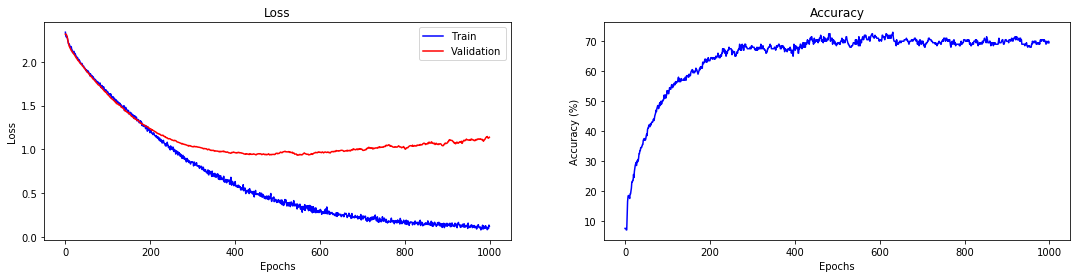

In [17]:
fig = plt.figure()
fig.subplots_adjust(right=2.5)

ax1 = fig.add_subplot(121)
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(train_losses, 'b-', label='Train')
ax1.plot(valid_losses, 'r-', label='Validation')
ax1.legend(loc='upper right')

ax1 = fig.add_subplot(122)
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.plot(accuracies, 'b-')

plt.show()